* Dataset used: user5.csv

# Step 1: Import the necessary libraries



In [1]:
#Pandas: Reading and analyzing data
import pandas as pd
#Numerical calcuations
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, SimpleRNN
#LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import Model

#Normalization
from sklearn.preprocessing import MinMaxScaler
#Evaluate MSE
from sklearn.metrics import mean_squared_error
#plot numpy array
import matplotlib.pyplot as plt
#Create Folder for modelling checkpoint
import os

# Step 2: Load and preprocess the data

In [2]:
df = pd.read_csv('user5.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,temp,hour,User5
0,2012-07-01 00:00:00,5.1,0,0.098
1,2012-07-01 01:00:00,5.1,1,0.098
2,2012-07-01 02:00:00,5.1,2,0.075
3,2012-07-01 03:00:00,2.7,3,0.072
4,2012-07-01 04:00:00,2.7,4,0.092


In [3]:
# Scaling function

def ScalerX(X_train, X_test):

    # Apply min-max scaling to temp and rhum columns
    scalerX = MinMaxScaler()

    # Fit the scaler on the training data
    X_train[['temp', 'User5']] = scalerX.fit_transform(X_train[['temp', 'User5']])
    X_test[['temp', 'User5']] = scalerX.transform(X_test[['temp', 'User5']])

    # Apply sine-cosine scaling to hour and dayofweek columns
    X_train['hour_sin'] = np.sin(2 * np.pi * X_train['hour'] / 24)
    X_train['hour_cos'] = np.cos(2 * np.pi * X_train['hour'] / 24)

    X_test['hour_sin'] = np.sin(2 * np.pi * X_test['hour'] / 24)
    X_test['hour_cos'] = np.cos(2 * np.pi * X_test['hour'] / 24)

    X_train = X_train.drop('hour', axis=1)
    X_test = X_test.drop('hour', axis=1)

    return X_train, X_test, scalerX


def ScalerY(y_train, y_test):

    # Create an instance of MinMaxScaler
    scalerY = MinMaxScaler()

    # Reshape the series to a 2D array (required by MinMaxScaler)
    y_train_reshaped = y_train.values.reshape(-1, 1)
    y_test_reshaped = y_test.values.reshape(-1, 1)

    # Apply MinMax scaling
    y_train_scaled = scalerY.fit_transform(y_train_reshaped)
    y_test_scaled = scalerY.transform(y_test_reshaped)

    # Convert the scaled array back to a Series
    y_train_scaled_series = pd.Series(y_train_scaled.flatten())
    y_test_scaled_series = pd.Series(y_test_scaled.flatten())

    return y_train_scaled_series, y_test_scaled_series, scalerY

# Function to create sequences or window generator
def create_sequences(X, y, time_steps):
  Xs, ys = [] , []
  for i in range(len(X) - time_steps):
    Xs.append(X.iloc[i:i+time_steps].values)
    ys.append(y.iloc[i+time_steps])

  return np.array(Xs), np.array(ys)



In [4]:
# Hyperparameters
TIME_STEPS = 24

# Split into input (X) and output (y) variables
X = df[['temp', 'hour', 'User5']]
y = df['User5']

# Train test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Apply scaling
X_train_scaled, X_test_scaled, scalerX = ScalerX(X_train, X_test)
y_train_scaled, y_test_scaled, scalerY = ScalerY(y_train, y_test)

# Create sequences with a time window of 24
X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, TIME_STEPS)
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, TIME_STEPS)

C:\Users\rs1044\AppData\Local\Temp\ipykernel_24976\2005558404.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['temp', 'User5']] = scalerX.fit_transform(X_train[['temp', 'User5']])
C:\Users\rs1044\AppData\Local\Temp\ipykernel_24976\2005558404.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[['temp', 'User5']] = scalerX.transform(X_test[['temp', 'User5']])
C:\Users\rs1044\AppData\Local\Temp\ipykernel_24976\2005558404.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [5]:
print(f' X_train shape: {X_train.shape}')     # Shape: (no of records, past observations, total features)
print(f'Y_train shape: {y_train.shape}')    # Shape: (no or records, )

print(f' X_test shape: {X_test.shape}')
print(f'Y_test shape: {y_test.shape}')

 X_train shape: (6984, 24, 4)
Y_train shape: (6984,)
 X_test shape: (1728, 24, 4)
Y_test shape: (1728,)


# Step 3: Define the Mixture of Experts model architecture


In [6]:
# define the LSTM model

def lstm_model(input_shape):

  model = Sequential()
  model.add(Bidirectional(LSTM(32, input_shape=input_shape, return_sequences=True)))  # Add return_sequences=True for multiple hidden layers
  model.add(Dropout(0.2)) # Add dropout between layers

  model.add(Bidirectional(LSTM(32)))        # Add another LSTM layer
  model.add(Dropout(0.2))

  model.add(Dense(1))       # Add output layer
  return model

# define the ResNet block
def resnet_model(input_shape):
  inputs = keras.Input(shape=input_shape)
  x = inputs

  x = Conv1D(filters=64, kernel_size=3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv1D(filters=64, kernel_size=3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  residual = Conv1D(filters=64, kernel_size=1, padding='same')(inputs)
  x = keras.layers.add([x, residual])
  x = Activation('relu')(x)

  # define the pooling and output layers
  x = GlobalAveragePooling1D()(x)
  x = Dense(50, activation='relu')(x)
  outputs = Dense(1)(x)

  # create the model
  model = Model(inputs=inputs, outputs=outputs)

  return model

# Define simple rnn model
def rnn_model(input_shape):

  model = Sequential()
  model.add(SimpleRNN(32, return_sequences=True, input_shape=input_shape))
  model.add(Dropout(0.2))

  model.add(SimpleRNN(32, return_sequences=True))
  model.add(Dropout(0.2))

  model.add(SimpleRNN(32))
  model.add(Dropout(0.2))

  model.add(Dense(1))

  return model

def mixture_of_experts(input_shape, expert_output):

  # Define inputs
  inputs = keras.Input(shape=input_shape)

  lstm = lstm_model(input_shape)(inputs)      # lstm model
  resnet = resnet_model(input_shape)(inputs)  # resnet model
  rnn = rnn_model(input_shape)(inputs)        # rnn model

  if (expert_output == 'summation'):
    expert_outputs = layers.add([lstm, resnet, rnn])

  elif (expert_output == 'average'):
    expert_outputs = layers.average([lstm, resnet, rnn])

  elif (expert_output == 'max pooling'):
    expert_outputs = layers.maximum([lstm, resnet, rnn])

  elif (expert_output == 'learnable weights'):
    expert_outputs = layers.concatenate([lstm, resnet, rnn])
    # Define gating network
    gates = layers.Dense(3, activation='softmax')(expert_outputs)
    # Weighted combination of expert outputs
    expert_outputs = layers.multiply([gates, expert_outputs])

  else:
    raise ValueError("Invalid technique for expert output.")

  outputs = layers.Dense(1)(expert_outputs)
  model = keras.Model(inputs, outputs)
  return model

# Define the input shape
input_shape = X_train.shape[1:]

In [8]:
# Hyperparameters
EXPERT_OUTPUT = ['summation', 'average', 'max pooling', 'learnable weights']

mses = []     # To store mse of each case
y_preds = []    # To store Y prediction of each case

# MAIN
for i in EXPERT_OUTPUT:

  # Create the Mixture of Experts model
  model = mixture_of_experts(input_shape, i)

  # Compile and train the model
  model.compile(optimizer='adam', loss='mse')
  model.fit(X_train, y_train, epochs=10, batch_size=32)

  # # Evaluate the model on the test set
  # test_mse = model.evaluate(X_test, y_test, verbose=0)
  # mses.append(test_mse)

  # make predictions
  y_pred = model.predict(X_test)
  y_preds.append(y_pred)

Epoch 1/10
219/219 [==============================] - 8s 11ms/step - loss: 0.0075
Epoch 2/10
219/219 [==============================] - 2s 11ms/step - loss: 0.0039
Epoch 3/10
219/219 [==============================] - 3s 11ms/step - loss: 0.0035
Epoch 4/10
219/219 [==============================] - 3s 12ms/step - loss: 0.0034
Epoch 5/10
219/219 [==============================] - 3s 11ms/step - loss: 0.0032
Epoch 6/10
219/219 [==============================] - 2s 11ms/step - loss: 0.0032
Epoch 7/10
219/219 [==============================] - 3s 11ms/step - loss: 0.0031
Epoch 8/10
219/219 [==============================] - 2s 11ms/step - loss: 0.0031
Epoch 9/10
219/219 [==============================] - 3s 11ms/step - loss: 0.0030
Epoch 10/10
54/54 [==============================] - 1s 3ms/step
Epoch 1/10
219/219 [==============================] - 8s 11ms/step - loss: 0.0040
Epoch 2/10
219/219 [==============================] - 2s 11ms/step - loss: 0.0036
Epoch 3/10
219/219 [=============

In [9]:
# DESCALE
from numpy.lib.function_base import append

y_preds_descaled = []

y_test_descaled = scalerY.inverse_transform(y_test.reshape(-1,1))
y_preds_descaled = [scalerY.inverse_transform(y_pred) for y_pred in y_preds]

In [10]:
# Calculate mse

new_mses =  [mean_squared_error(y_test_descaled, y_preds_descaled[i]) for i in range(0,len(y_preds_descaled))]

In [11]:
new_mses

[0.13594206986720958,
 0.12346056717960295,
 0.12452941222063735,
 0.13692984756975612]

# 4. Visualization

In [12]:
mses

[]

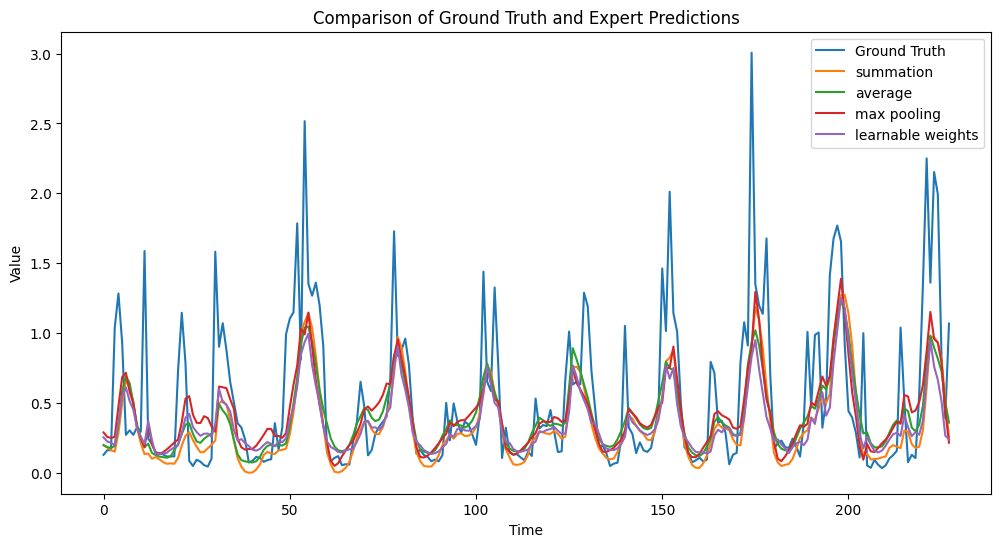

In [13]:
# SCALED

plt.figure(figsize=(12, 6))

# Plot ground truth
plt.plot(y_test_descaled[1500:], label='Ground Truth')

# Plot predictions from different experts
plt.plot(y_preds_descaled[0][1500:], label=EXPERT_OUTPUT[0])
plt.plot(y_preds_descaled[1][1500:], label=EXPERT_OUTPUT[1])
plt.plot(y_preds_descaled[2][1500:], label=EXPERT_OUTPUT[2])
plt.plot(y_preds_descaled[3][1500:], label=EXPERT_OUTPUT[3])

# Set plot title and axis labels
plt.title('Comparison of Ground Truth and Expert Predictions')
plt.xlabel('Time')
plt.ylabel('Value')

# Add legend
plt.legend()

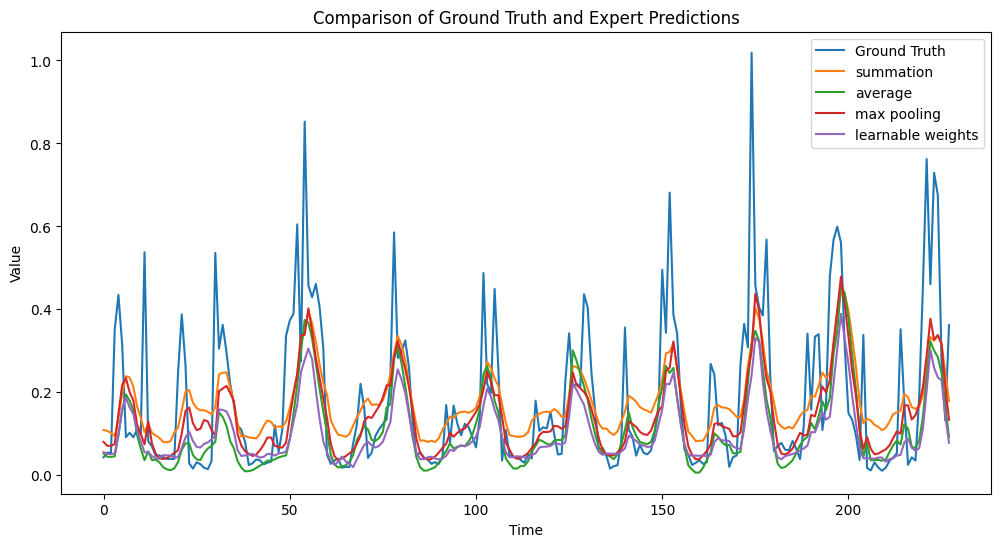

In [13]:
# Without scaling

plt.figure(figsize=(12, 6))

# Plot ground truth
plt.plot(y_test[1500:], label='Ground Truth')

# Plot predictions from different experts
plt.plot(y_preds[0][1500:], label=EXPERT_OUTPUT[0])
plt.plot(y_preds[1][1500:], label=EXPERT_OUTPUT[1])
plt.plot(y_preds[2][1500:], label=EXPERT_OUTPUT[2])
plt.plot(y_preds[3][1500:], label=EXPERT_OUTPUT[3])

# Set plot title and axis labels
plt.title('Comparison of Ground Truth and Expert Predictions')
plt.xlabel('Time')
plt.ylabel('Value')

# Add legend
plt.legend()